# njit compile for `map_rows`

`map_rows` is applying user-defined function to the nested frame with row-wise operations. This can be optimized with pre-compilation using tools like Numba Just-in-Time (njit) compilation. 

If the custom function is jit-complied, it makes sense to have `map_rows` logic also be jit-complied to match with it. Thus, we rewrite the looping logic for row-wise operation inside `map_rows` with njit to potentially achieve more optimization. 

## Usage and Limitations

Since functions decorated with `@njit` will have `CPUDispatcher` type, the method will check the type for custom function directly. Simply call `map_rows` with a njit user function, and the method will detect whether the current njit optimization is applicable. If not, it will fall back to non-jitted execution to ensure the output.

The current njit optimization for `map_rows` have several limitations:
 - Only support `row_container="args"` since njit does not accept dynamic typing.
 - Only support custom function with only **one** or **two** arguments. 
    - This is becauase njit compilation requires strict static typing. We will need to preprocess the input columns into forms compatible with Numba’s type system, which requires multiple cases for more arguments.
    <!-- - We will need to have separate logic to handle different cases of mixing base and nested column arguments. -->
 - The performance gains decrease as nested column width increases. For larger nested columns, data movement and copying overhead dominate runtime, causing the njit implementation to provide little benefit and eventually to be outperformed by the default python execution.

## Examples and Benchmark

We will show some examples to demonstrate the function and introduce some variations that could affect the performance. Then, we will benchmark on the runtime and compare the result with the default python implementation. 

In [2]:
from nested_pandas.datasets import generate_data
import numpy as np
from numba import njit

# example frame
nf = generate_data(10_000, 1000, seed=1)

In [3]:
# benchmarking setup
import timeit
import matplotlib.pyplot as plt

n_nested_list = [100, 200, 300, 500, 750, 1000, 1250, 1500]
n_base_list = [7500, 10_000, 12_500, 15_000]

def bench(func, nf):
    timings = timeit.repeat(
        lambda: func(nf.copy()),
        number=10,
        repeat=5,
    )
    timings = np.array(timings)
    return timings.mean(), timings.std()

def plot_bench(py_func, njit_func, title, n_base_list=n_base_list, n_nested_list=n_nested_list):
    plt.figure()
    for n_base in n_base_list:
        speedups = []
        speedup_errs = []

        for n_nested in n_nested_list:
            nf = generate_data(n_base, n_nested, seed=1)    # build frame for each size

            mean_py, std_py = bench(py_func, nf)    # python bench
            mean_njit, std_njit = bench(njit_func, nf)   # njit bench

            speedup = mean_py / mean_njit   # mean speedup ratio

            # error propagation for ratio (absolute uncertainty, covariance = 0)
            speedup_std = speedup * np.sqrt(
                (std_py / mean_py) ** 2 +
                (std_njit / mean_njit) ** 2
            )

            speedups.append(speedup)
            speedup_errs.append(speedup_std)

        plt.errorbar(
            n_nested_list,
            speedups,
            yerr=speedup_errs,
            marker='o',
            capsize=4,
            alpha=0.6,
            label=f'base_row_num={n_base}'
        )

    plt.axhline(1.0, linestyle='--')  # baseline
    plt.xlabel("Nested Columns Width")
    plt.ylabel("Speedup (py / njit)")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

We will benchmark each example function on four cases (different number of base rows). Each case will also be tested on different nested columns width associated with it, ranging from 100 to 1500 to see the trend. The benchmark will repeat the trials to reduce measurement noise: each trial will execute the testing function 10 consecutive times and record the total time spent; repeat the trial 5 times to get 5 timing values. We will use these timing measurements to graph the ratio of benchmark results with error propagation. 

### Max Slope

This user-defined function takes in two nested columns as arguments. Below are two exact implementation, one with `@njit` decorator and one without. 

In [4]:
def max_slope_py(t, flux):
    slope = np.diff(flux) / np.diff(t)
    return np.max(slope)

@njit
def max_slope_njit(t, flux):
    slope = np.diff(flux) / np.diff(t)
    return np.max(slope)

njit version of `map_rows` can be called the same as before, just with the user-defined function being jit-compiled.

In [5]:
nf.map_rows(
    max_slope_njit, 
    columns=["nested.t", "nested.flux"], 
    row_container="args", 
    output_names="max_slope"
)

,max_slope
0,1457.847680
1,1896.818754
...,...
9998,11857.643016
9999,3817.902314


The result should be the same with default python execusion.

In [6]:
nf.map_rows(
    max_slope_py, 
    columns=["nested.t", "nested.flux"], 
    row_container="args", 
    output_names="max_slope"
)

,max_slope
0,1457.847680
1,1896.818754
...,...
9998,11857.643016
9999,3817.902314


Now we benchmark on the performance to see the runtime. The plot shows the ratio of python execution time / njit execution time, which indicates the approximate speedup njit optimization brings. We would want to see the ratio to be greater than one to indicate njit execution is faster than python.

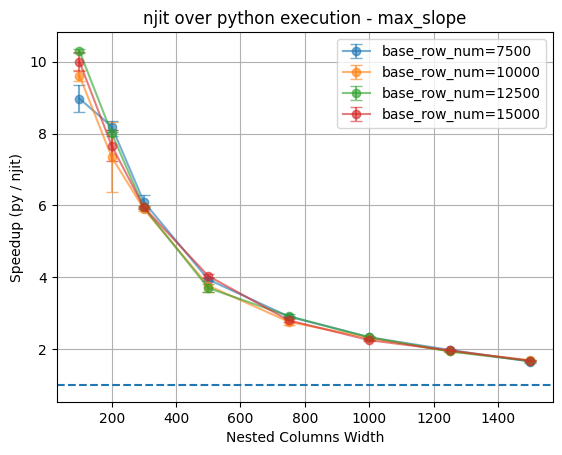

In [20]:
# define helpers for benchmarking
def run_max_slope_py(nf):
    nf.map_rows(
        max_slope_py, 
        columns=["nested.t", "nested.flux"], 
        row_container="args", 
        output_names="max_slope"
    )

def run_max_slope_njit(nf):
    nf.map_rows(
        max_slope_njit, 
        columns=["nested.t", "nested.flux"], 
        row_container="args", 
        output_names="max_slope"
    )

run_max_slope_njit(nf.copy())  # run njit once for compilation before benchmark

plot_bench(
    run_max_slope_py, 
    run_max_slope_njit, 
    title="njit over python execution - max_slope"
)

As the plot shown, for small nested column widths (i.e. 100), the njit implementation achieves performance gains of ~9× speedup across all four base row configurations. However, as the nested column width increases, the speedup decays, reaching less than 2× at the largest tested width (i.e. 1500).

Notably, the speedup curves for different base row counts almost completely overlap, indicating that the number of base rows is not the main factor that affect relative performance of njit. Instead, the nested column width has greater impact.

For an asymptotic behavior, we will increase the number of nested column width and see the effect. The number of base row cases is reduced to two to limit time for graph generation. However, the results continue to show that base row has little impact on relative performance.

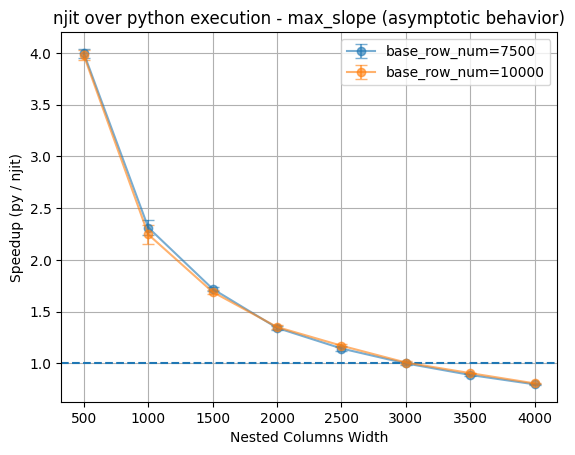

In [8]:
n_base_shrink = [7500, 10_000]
n_nested_list_asy = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

plot_bench(
    run_max_slope_py,
    run_max_slope_njit,
    title="njit over python execution - max_slope (asymptotic behavior)",
    n_base_list=n_base_shrink,
    n_nested_list=n_nested_list_asy
)


The result shows the njit optimization actually loses its performance advantage when nested column width exceeds approximately 3000 entries, beyond which the default python implementaiton becomes more efficient. This number may varies depending on the custom function given, but we can see in the later examples too that this trend is persistent. This graph may indicates that the computational overhead for njit compilation (maybe for numpy function calls) outweights the benegits it brings at larger nested column widths. 

### Weighted Mean Slope

This function takes in two nested columns as arguments. It has more numpy function calls and more computations.

In [10]:
def weighted_mean_slope_py(t, flux):
    dt = np.diff(t)
    df = np.diff(flux)

    slopes = df / dt
    weights = dt
    return np.sum(slopes * weights) / np.sum(weights)

@njit
def weighted_mean_slope_njit(t, flux):
    dt = np.diff(t)
    df = np.diff(flux)

    slopes = df / dt
    weights = dt
    return np.sum(slopes * weights) / np.sum(weights)

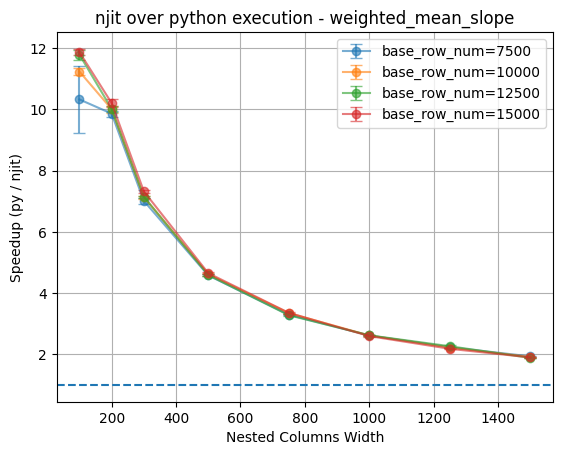

In [18]:
def run_weighted_mean_slope_py(nf):
    nf.map_rows(
        weighted_mean_slope_py, 
        columns=["nested.t", "nested.flux"], 
        row_container="args", 
        output_names="weighted_mean_slope"
    )

def run_weighted_mean_slope_njit(nf):
    nf.map_rows(
        weighted_mean_slope_njit,
        columns=["nested.t", "nested.flux"], 
        row_container="args", 
        output_names="weighted_mean_slope"
    )

run_weighted_mean_slope_njit(nf.copy())  # run njit once for compilation before benchmark

plot_bench(
    run_weighted_mean_slope_py, 
    run_weighted_mean_slope_njit, 
    title="njit over python execution - weighted_mean_slope"
)

Again, we observe a similar trend with this two-argument custom function. This similarity suggests that the observed performance behavior is not specific to a particular function implementation. In both cases, nested column width is the primary factor influencing the effectiveness of the njit optimization.

This behavior might also indicates that the performance bottleneck for njit execution is dominated by the nested data access, rather than by the specific computation inside the custom function or the row-wise invocation pattern.

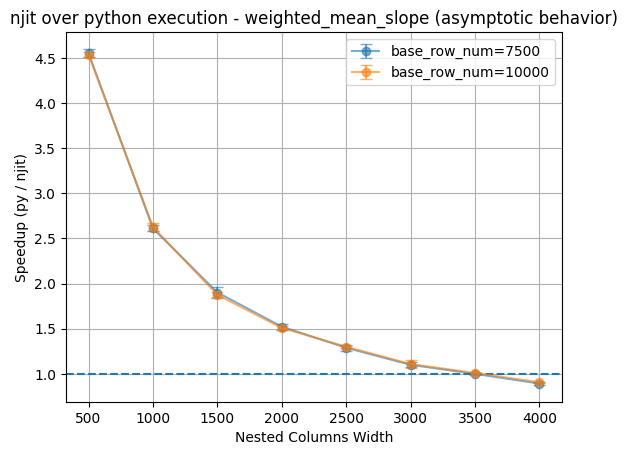

In [13]:
n_base_shrink = [7500, 10_000]
n_nested_list_asy = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

plot_bench(
    run_weighted_mean_slope_py,
    run_weighted_mean_slope_njit,
    title="njit over python execution - weighted_mean_slope (asymptotic behavior)",
    n_base_list=n_base_shrink,
    n_nested_list=n_nested_list_asy
)

Again for asymptotic behavior, we can see the trend of njit loosing its advantage as nested columns grew larger. For this function, the breaking point is at approximately 3500 entries for nested columns.

However, an interesting note here is that since Numba will translate the python code into machine code for faster execution, it favors the explicit manual loop without any call to numpy functions. We can see that from this example:

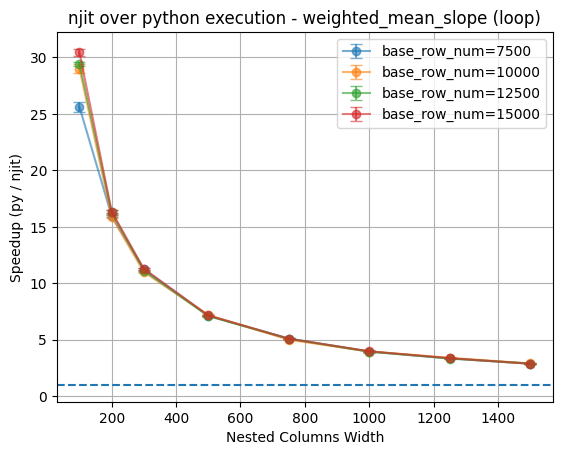

In [19]:
@njit
def weighted_mean_slope_njit_loop(t, flux):
    n = t.size - 1
    num = 0.0
    weight = 0.0

    # manually looping to get the difference and summing up
    for i in range(n):
        dt = t[i + 1] - t[i]
        df = flux[i + 1] - flux[i]

        slope = df / dt
        num += slope * dt
        weight += dt

    return num / weight

def run_weighted_mean_slope_njit_loop(nf):
    nf.map_rows(
        weighted_mean_slope_njit_loop,
        columns=["nested.t", "nested.flux"], 
        row_container="args", 
        output_names="weighted_mean_slope"
    )
    
run_weighted_mean_slope_njit_loop(nf.copy())  # run njit once for compilation before benchmark

plot_bench(
    run_weighted_mean_slope_py, 
    run_weighted_mean_slope_njit_loop, 
    title="njit over python execution - weighted_mean_slope (loop)"
)

The result shows that although both custom functions are njit-compiled, the one that explicitly implement the logic with manual looping achieves a much larger 25-30x speedup comparing to the standard function that uses numpy calls (~11x speedup). 

This might be becasue Numba will treat numpy functions as external library calls with limited opportunity to optimize, while explicit loops allows Numba to fully optimize the control flow and produce very efficient machine code.

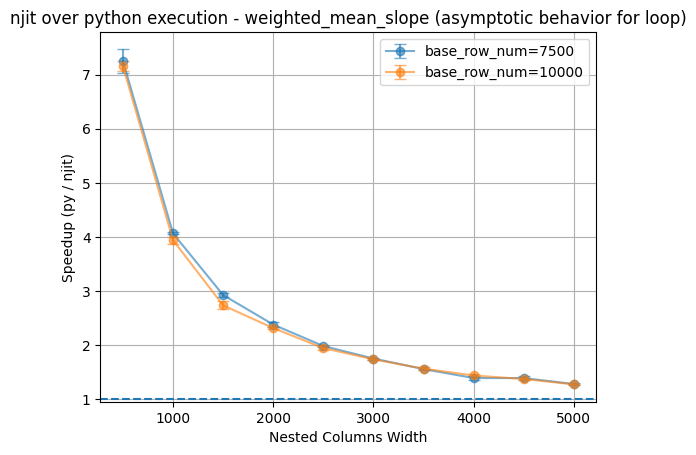

In [21]:
n_base_shrink = [7500, 10_000]
n_nested_list_asy = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

plot_bench(
    run_weighted_mean_slope_py,
    run_weighted_mean_slope_njit_loop,
    title="njit over python execution - weighted_mean_slope (asymptotic behavior for loop)",
    n_base_list=n_base_shrink,
    n_nested_list=n_nested_list_asy
)

The asymptotic behavior for this version of the njit custom function does not go pass the base line. It still remains a very slight advantage even when the nested columns width reached 5000. Although we recognize that writing such code is not the normal practice, it is something to consider about. 

### Scaled Max Flux

This function takes in two arguments with mixing type: a nested column vector with a base column scalar.

In [22]:
def scaled_max_flux_py(flux, a):
    """
    flux: 1D array (nested slice)
    a: scalar (base column value)
    """
    return a * np.max(flux)

@njit
def scaled_max_flux_njit(flux, a):
    """
    flux: 1D array (nested slice)
    a: scalar (base column value)
    """
    return a * np.max(flux)

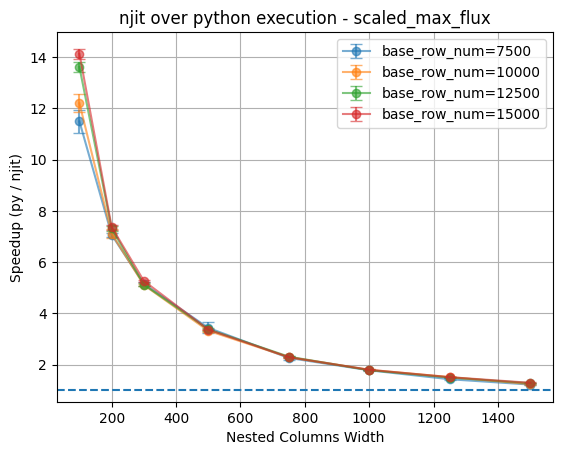

In [23]:
def run_scaled_max_flux_py(nf):
    nf.map_rows(
        scaled_max_flux_py,
        columns=["nested.flux", "a"],
        row_container="args",
        output_names="scaled_max_flux",
    )

def run_scaled_max_flux_njit(nf):
    nf.map_rows(
        scaled_max_flux_njit,
        columns=["nested.flux", "a"],
        row_container="args",
        output_names="scaled_max_flux",
    )

run_scaled_max_flux_njit(nf.copy())  # run once for jit compilation before benchmark

plot_bench(
    run_scaled_max_flux_py, 
    run_scaled_max_flux_njit, 
    title="njit over python execution - scaled_max_flux"
)

Again, we can see that similar trend.

Due to the limitation of fixed typing required by njit, we need explicit cases for all different combinations of argument types. This is the reason why current implementation only support njit optimization with two arguments of mixing type. 

There is a potential solution to address this issue, that is to "explode" the base argument into the nested columns and pass both arguments as nested value. This way we can reduce all mixing type arguments to just one case. 

In [24]:
@njit
def scaled_max_flux_njit_explode(flux, a):
    """
    flux: 1D array (nested slice)
    a: scalar vector (base column value exploded into nested column)
    """
    return a[0] * np.max(flux)

nf["nested.a"] = nf["a"] # explode base column into nested column
nf.map_rows(
    scaled_max_flux_njit_explode,
    columns=["nested.flux", "nested.a"],    # then input both arguments as nested column
    row_container="args",
    output_names="scaled_max_flux",
)

,scaled_max_flux
0,41.684996
1,71.987295
...,...
9998,10.803349
9999,76.051366


However, this operation becomes inefficient at larger nested column widths, where the overhead of copying data from the base column into the nested column dominates execution time.

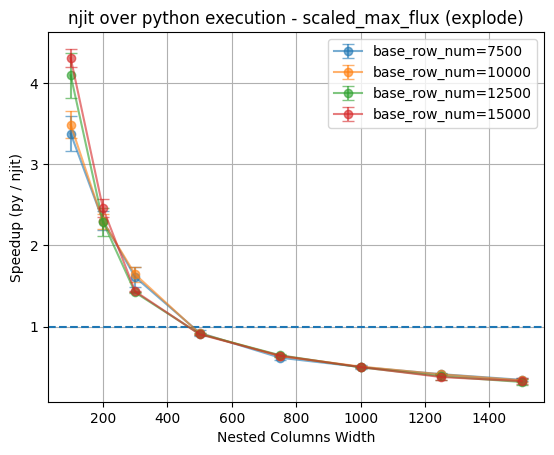

In [25]:
# explode graph
def run_scaled_max_flux_njit_explode(nf):
    nf["nested.a"] = nf["a"]
    nf.map_rows(
        scaled_max_flux_njit_explode,
        columns=["nested.flux", "nested.a"],
        row_container="args",
        output_names="scaled_max_flux",
    )

run_scaled_max_flux_njit_explode(nf.copy())  # run once for jit compilation before benchmark

plot_bench(
    run_scaled_max_flux_py, 
    run_scaled_max_flux_njit_explode, 
    title="njit over python execution - scaled_max_flux (explode)"
)

The time required by the explosion outweighs the performance gains njit provided at the breaking point of 500 entries for all four cases.

### Sum of max 3

For the custom functions with more than two arguments, `map_rows` will fall back to the default python execution and provide a warning. However, the njit custom function may still provide some speedup depending on the function itself.

For example, this function takes in three arguments of mixing type.


In [26]:
@njit
def sum_max3_njit(a, t, flux):
    return a + np.max(t) + np.max(flux)

def sum_max3_py(a, t, flux):
    return a + np.max(t) + np.max(flux)

/var/folders/tm/h1tgp0n52pj_t7mqqw12kv4r0000gn/T/ipykernel_1682/1284420436.py:10: UserWarning: For performance, njit functions with `row_container='args'` only support 1 or 2 arguments. Falling back to non-jitted execution.
  nf.map_rows(
/var/folders/tm/h1tgp0n52pj_t7mqqw12kv4r0000gn/T/ipykernel_1682/1284420436.py:2: UserWarning: For performance, njit functions with `row_container='args'` only support 1 or 2 arguments. Falling back to non-jitted execution.
  nf.map_rows(
/var/folders/tm/h1tgp0n52pj_t7mqqw12kv4r0000gn/T/ipykernel_1682/1284420436.py:2: UserWarning: For performance, njit functions with `row_container='args'` only support 1 or 2 arguments. Falling back to non-jitted execution.
  nf.map_rows(
/var/folders/tm/h1tgp0n52pj_t7mqqw12kv4r0000gn/T/ipykernel_1682/1284420436.py:2: UserWarning: For performance, njit functions with `row_container='args'` only support 1 or 2 arguments. Falling back to non-jitted execution.
  nf.map_rows(
/var/folders/tm/h1tgp0n52pj_t7mqqw12kv4r0000gn/

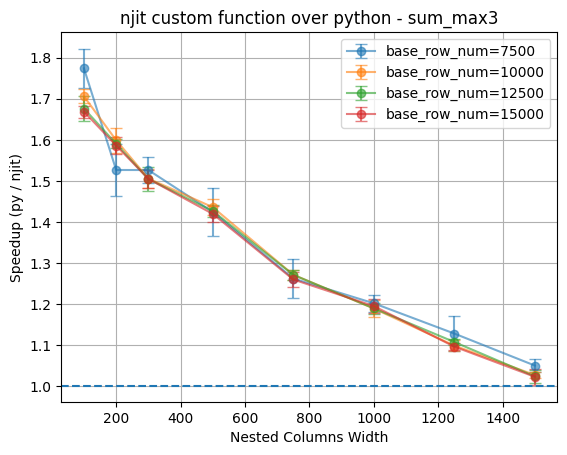

In [27]:
def run_sum_max3_py(nf):
    nf.map_rows(
        sum_max3_py, 
        columns=["a", "nested.t", "nested.flux"], 
        row_container="args", 
        output_names="max_3"
    )

def run_sum_max3_njit(nf):
    nf.map_rows(
        sum_max3_njit,
        columns=["a", "nested.t", "nested.flux"],
        row_container="args",
        output_names="max_3",
    )

run_sum_max3_njit(nf.copy())  # run once for jit compilation before benchmark

plot_bench(
    run_sum_max3_py, 
    run_sum_max3_njit, 
    title="njit custom function over python - sum_max3"
)

As shown in the graph, the optimization for njit function decrease linearly as increasing nested column width increase, which is expected.

## Takeaways

- njit optimization can provide substantial speedups, but only for smaller nested column widths. The performance gain diminish quickly as nested column width increases.

- Nested column width is the dominant factor that affect relative performance. Across all the example functions, the benchmark results for different base row counts almost completely overlap with little variations.

- We recognize that users might want to use this optimization for more complex functions. However, base on the requirement for strict static typing, it is hard to extend the current logic to support general usage for more mix-type arguments.

- Asymptotically, njit execution may lose to default python execution. In extended benchmarks with larger nested column width, the njit execution eventually becomes slower than default python execution. Ultimately, data movement and memort access cost dominate execution time, making njit compilation ineffective.
